<h1 style="font-size:120%; color:#888888;"><b> Exploratory Data Analysis </b></h1>

In [1]:
%%time

#!pip install -U tornado
!pip install --user tornado
!pip install "dask[complete]"

CPU times: total: 15.6 ms
Wall time: 6.15 s


In [2]:
import warnings
warnings.filterwarnings("ignore")
import shutil
import os
import pandas as pd
import matplotlib
matplotlib.use(u'nbAgg')
import matplotlib.pyplot as plt
import seaborn as sns

import numpy as np
from tqdm import tqdm
import pickle
from sklearn.manifold import TSNE
from sklearn import preprocessing
import pandas as pd
from multiprocessing import Process # this is used for multithreading
import multiprocessing
import codecs# this is used for file operations 
import random as r
from xgboost import XGBClassifier
from sklearn.model_selection import RandomizedSearchCV
from sklearn.tree import DecisionTreeClassifier
from sklearn.calibration import CalibratedClassifierCV
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import log_loss
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
import re
from nltk.util import ngrams
from sklearn.feature_selection import SelectKBest, chi2, f_regression

import scipy.sparse
import gc
import pickle as pkl
from datetime import datetime as dt
import dask.dataframe as dd

In [3]:
# separating byte files and asm files 
# Below is from AML Assignment file
'''
from google.colab import drive
drive.mount('/content/gdrive')
root_path = '/content/gdrive/MyDrive/AML_Malware/Full_data/'
'''
root_path = 'train/train/'

In [4]:
#separating byte files and asm files 

source = 'train/train/'
destination_1 = 'train/byteFiles'
destination_2 = 'train/asmFiles'

# we will check if the folder 'byteFiles' exists 
# if it not, there we will create a folder with the same name
if not os.path.isdir(destination_1):
    os.makedirs(destination_1)
if not os.path.isdir(destination_2):
    os.makedirs(destination_2)

# if we have folder called 'train' (train folder contains both .asm files and .bytes files), 
# we will rename it 'asmFiles' for every file that we have in our 'asmFiles' directory 
# we check if it is ending with .bytes, if yes we will move it to 'byteFiles' folder

# so by the end of this snippet we will separate all the .byte files and .asm files
if os.path.isdir(source):
    data_files = os.listdir(source)
    for file in data_files:
        #print(file)
        if (file.endswith("bytes")):
            shutil.move(source+'\\'+file,destination_1)
        if (file.endswith("asm")):
            shutil.move(source+'\\'+file,destination_2)

<h1 style="font-size:120%; color:#888888;"><b> Distribution of malware classes in whole data set <a id="8"></a></b></h1>

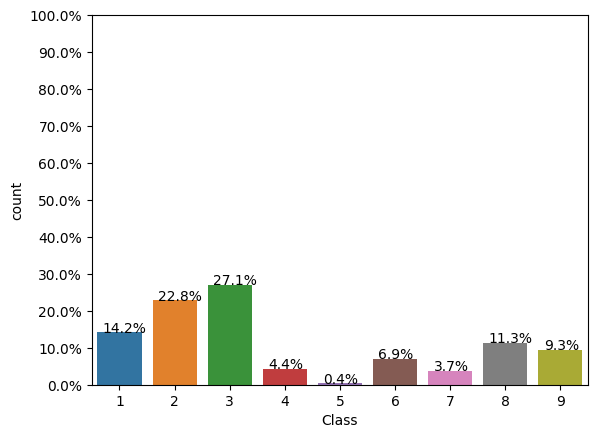

In [5]:
%matplotlib inline
Y = pd.read_csv("train/trainLabels.csv")
total = len(Y)*1. # total = 10868.0, len(Y) = 10,868
ax = sns.countplot(x="Class", data=Y)

for p in ax.patches:
        ax.annotate('{:.1f}%'.format(100*p.get_height()/total), (p.get_x()+0.1, p.get_height()+5))

#put 11 ticks (therefore 10 steps), from 0 to the total number of rows in the dataframe
ax.yaxis.set_ticks(np.linspace(0, total, 11))

#adjust the ticklabel to the desired format, without changing the position of the ticks. 
ax.set_yticklabels(map('{:.1f}%'.format, 100*ax.yaxis.get_majorticklocs()/total))
plt.show()

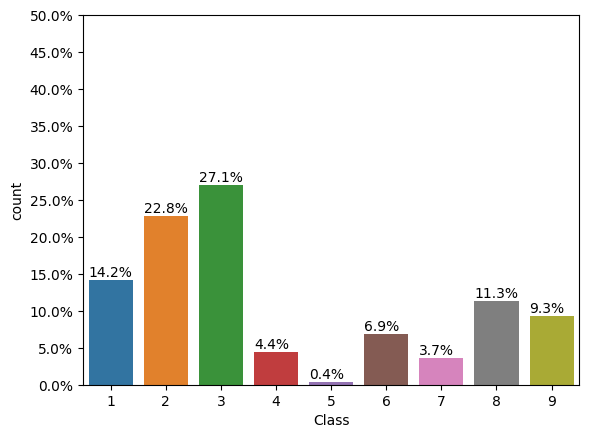

In [6]:
%matplotlib inline
Y = pd.read_csv("train/trainLabels.csv")
total = len(Y)*1. # total = 10868.0, len(Y) = 10,868
ax = sns.countplot(x="Class", data=Y)
for p in ax.patches:
    ax.annotate('{:.1f}%'.format(100*p.get_height()/total), (p.get_x(), p.get_height()+50))

#put 11 ticks (therefore 10 steps), from 0 to the total number of rows in the dataframe
ax.yaxis.set_ticks(np.linspace(0, total/2, 11))

#adjust the ticklabel to the desired format, without changing the position of the ticks. 
ax.set_yticklabels(map('{:.1f}%'.format, 100*ax.yaxis.get_majorticklocs()/total))
plt.show()

In [7]:
ax.patches

<Axes.ArtistList of 9 patches>

## 1. Byte Files Features
<h1 style="font-size:120%"><b> File size  of byte files as a feature <a id="9"></a> </b></h1>

In [8]:
#file sizes of byte files

files = os.listdir('train/byteFiles')
filenames = Y['Id'].tolist()
class_y = Y['Class'].tolist()
class_bytes = []
sizebytes = []
fnames = []

print(os.stat('train/byteFiles/'+files[0]))

os.stat_result(st_mode=33206, st_ino=12384898975371692, st_dev=283786277, st_nlink=1, st_uid=0, st_gid=0, st_size=4440576, st_atime=1629568600, st_mtime=1629568600, st_ctime=1629568600)


In [9]:
#print(os.stat('byteFiles/0A32eTdBKayjCWhZqDOQ.txt'))
#os.stat_result(st_mode=33206, st_ino=1125899906874507, st_dev=3561571700, st_nlink=1, st_uid=0, st_gid=0, 
#st_size=3680109, st_atime=1519638522, st_mtime=1519638522, st_ctime=1519638522)
# read more about os.stat: here https://www.tutorialspoint.com/python/os_stat.htm

In [10]:
for file in files:
    statinfo = os.stat('train/byteFiles/'+file)
    # split the file name at '.' and take the first part of it i.e the file name
    file = file.split('.')[0]
    if any(file == filename for filename in filenames):
        i = filenames.index(file)
        class_bytes.append(class_y[i])
        # converting into Mb's
        sizebytes.append(statinfo.st_size/(1024.0*1024.0))
        fnames.append(file)

data_size_byte = pd.DataFrame({'ID':fnames,'size':sizebytes,'Class':class_bytes})
print(data_size_byte.head())

                     ID      size  Class
0  01azqd4InC7m9JpocGv5  4.234863      9
1  01IsoiSMh5gxyDYTl4CB  5.538818      2
2  01jsnpXSAlgw6aPeDxrU  3.887939      9
3  01kcPWA9K2BOxQeS5Rju  0.574219      1
4  01SuzwMJEIXsK7A8dQbl  0.370850      8


<h1 style="font-size:120%"><b> box plots of file size (.byte files) feature <a id="10"></a></b></h1>

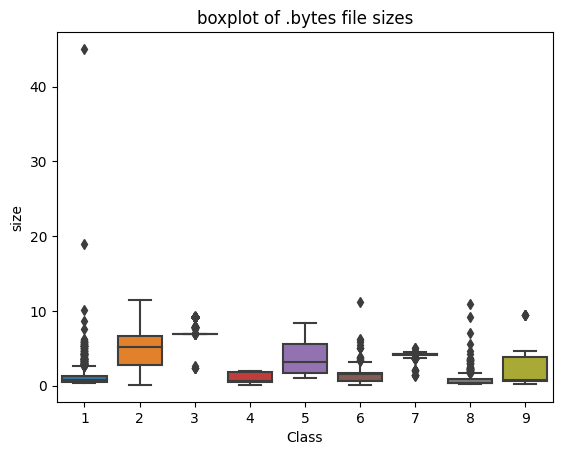

In [11]:
#boxplot of byte files
ax = sns.boxplot(x="Class", y="size", data=data_size_byte)
plt.title("boxplot of .bytes file sizes")
plt.show()

<h1 style="font-size:120%"><b> Uni-Gram Byte Feature extraction from byte files <a id="11"></a> </b></h1>

In [12]:
# removal of address from byte files
# contents of .byte files
# ----------------
# 00401000 56 8D 44 24 08 50 8B F1 E8 1C 1B 00 00 C7 06 08 
# -------------------
# we remove the starting address 00401000

files = os.listdir('train/byteFiles')
filenames = []
array = []
for file in files:
    if(file.endswith("bytes")):
        file = file.split('.')[0]
        text_file = open('train/byteFiles/'+file+".txt", 'w+')
        with open('train/byteFiles/'+file+".bytes","r") as fp:
            lines = ""
            for line in fp:
                a = line.rstrip().split(" ")[1:]
                b = ' '.join(a)
                b = b+"\n"
                text_file.write(b)
            fp.close()
            os.remove('train/byteFiles/'+file+".bytes")
        text_file.close()

files = os.listdir('train/byteFiles')
filenames2 = []
feature_matrix = np.zeros((len(files),257),dtype=int)

##### Program to convert into bag of words of bytefiles  
This is custom-built bag of words, this is unigram bag of words  
This is a Custom Implementation of CountVectorizer as CountVectorizer will NOT suport working on such huge file system of 50GB
For this Uni-Gram feature creating and writing to a file named 'result.csv'

Very long time to process ; 3H 14M 44S
We produced the result.csv previously and then used it when we coded this notebook without changing bytefiles.

In [11]:
byte_feature_file = 'train/result.csv'

if not os.path.isfile(byte_feature_file):
    byte_feature_file = open('train/result.csv','w+')
    byte_feature_file.write("ID,0,1,2,3,4,5,6,7,8,9,0a,0b,0c,0d,0e,0f,10,11,12,13,14,15,16,17,18,19,1a,1b,1c,1d,1e,1f,20,21,22,23,24,25,26,27,28,29,2a,2b,2c,2d,2e,2f,30,31,32,33,34,35,36,37,38,39,3a,3b,3c,3d,3e,3f,40,41,42,43,44,45,46,47,48,49,4a,4b,4c,4d,4e,4f,50,51,52,53,54,55,56,57,58,59,5a,5b,5c,5d,5e,5f,60,61,62,63,64,65,66,67,68,69,6a,6b,6c,6d,6e,6f,70,71,72,73,74,75,76,77,78,79,7a,7b,7c,7d,7e,7f,80,81,82,83,84,85,86,87,88,89,8a,8b,8c,8d,8e,8f,90,91,92,93,94,95,96,97,98,99,9a,9b,9c,9d,9e,9f,a0,a1,a2,a3,a4,a5,a6,a7,a8,a9,aa,ab,ac,ad,ae,af,b0,b1,b2,b3,b4,b5,b6,b7,b8,b9,ba,bb,bc,bd,be,bf,c0,c1,c2,c3,c4,c5,c6,c7,c8,c9,ca,cb,cc,cd,ce,cf,d0,d1,d2,d3,d4,d5,d6,d7,d8,d9,da,db,dc,dd,de,df,e0,e1,e2,e3,e4,e5,e6,e7,e8,e9,ea,eb,ec,ed,ee,ef,f0,f1,f2,f3,f4,f5,f6,f7,f8,f9,fa,fb,fc,fd,fe,ff,??")
    byte_feature_file.write("\n")

    k = 0
    for file in tqdm(files):
        filenames2.append(file)
        byte_feature_file.write(file+",")

        if(file.endswith("txt")):
            with open('train/byteFiles/'+file,"r") as byte_flie:
                for lines in byte_flie:
                    line = lines.rstrip().split(" ")
                    for hex_code in line:
                        if hex_code == '??':
                            feature_matrix[k][256]+=1
                        else:
                            feature_matrix[k][int(hex_code,16)]+=1
            byte_flie.close()

        for i, row in enumerate(feature_matrix[k]):
            if i != len(feature_matrix[k])-1:
                byte_feature_file.write(str(row)+",")
            else:
                byte_feature_file.write(str(row))
        byte_feature_file.write("\n")
    
        k += 1

    byte_feature_file.close()

In [13]:
byte_features = pd.read_csv("train/result.csv")
byte_features['ID'].str.split('.').str[0]

0        01azqd4InC7m9JpocGv5
1        01IsoiSMh5gxyDYTl4CB
2        01jsnpXSAlgw6aPeDxrU
3        01kcPWA9K2BOxQeS5Rju
4        01SuzwMJEIXsK7A8dQbl
                 ...         
10863    loIP1tiwELF9YNZQjSUO
10864    LOP6HaJKXpkic5dyuVnT
10865    LOqA6FX02GWguYrI1Zbe
10866    LoWgaidpb2IUM5ACcSGO
10867    lS0IVqXeJrN6Dzi9Pap1
Name: ID, Length: 10868, dtype: object

In [14]:
byte_features = pd.read_csv("train/result.csv")
byte_features['ID'] = byte_features['ID'].str.split('.').str[0]
byte_features.head(3)

,ID,0,1,2,3,4,5,6,7,8,...,f7,f8,f9,fa,fb,fc,fd,fe,ff,??
0,01azqd4InC7m9JpocGv5,601905,3905,2816,3832,3345,3242,3650,3201,2965,...,2804,3687,3101,3211,3097,2758,3099,2759,5753,1824
1,01IsoiSMh5gxyDYTl4CB,39755,8337,7249,7186,8663,6844,8420,7589,9291,...,451,6536,439,281,302,7639,518,17001,54902,8588
2,01jsnpXSAlgw6aPeDxrU,93506,9542,2568,2438,8925,9330,9007,2342,9107,...,2325,2358,2242,2885,2863,2471,2786,2680,49144,468


In [15]:
data_size_byte.head(3)

,ID,size,Class
0,01azqd4InC7m9JpocGv5,4.234863,9
1,01IsoiSMh5gxyDYTl4CB,5.538818,2
2,01jsnpXSAlgw6aPeDxrU,3.887939,9


In [16]:
byte_features_with_size = byte_features.merge(data_size_byte, on='ID')
byte_features_with_size.to_csv("result_with_size.csv")
byte_features_with_size.head(3)

,ID,0,1,2,3,4,5,6,7,8,...,f9,fa,fb,fc,fd,fe,ff,??,size,Class
0,01azqd4InC7m9JpocGv5,601905,3905,2816,3832,3345,3242,3650,3201,2965,...,3101,3211,3097,2758,3099,2759,5753,1824,4.234863,9
1,01IsoiSMh5gxyDYTl4CB,39755,8337,7249,7186,8663,6844,8420,7589,9291,...,439,281,302,7639,518,17001,54902,8588,5.538818,2
2,01jsnpXSAlgw6aPeDxrU,93506,9542,2568,2438,8925,9330,9007,2342,9107,...,2242,2885,2863,2471,2786,2680,49144,468,3.887939,9


In [17]:
# https://stackoverflow.com/a/29651514
def normalize(df):
    result1 = df.copy()
    for feature_name in df.columns:
        if (str(feature_name) != str('ID') and str(feature_name)!=str('Class')):
            max_value = df[feature_name].max()
            min_value = df[feature_name].min()
            result1[feature_name] = (df[feature_name] - min_value) / (max_value - min_value)
    return result1

result = normalize(byte_features_with_size)

data_y = result['Class']
result.head()

,ID,0,1,2,3,4,5,6,7,8,...,f9,fa,fb,fc,fd,fe,ff,??,size,Class
0,01azqd4InC7m9JpocGv5,0.262806,0.005498,0.001567,0.002067,0.002048,0.001835,0.002058,0.002946,0.002638,...,0.013560,0.013107,0.013634,0.031724,0.014549,0.014348,0.007843,0.000129,0.092219,9
1,01IsoiSMh5gxyDYTl4CB,0.017358,0.011737,0.004033,0.003876,0.005303,0.003873,0.004747,0.006984,0.008267,...,0.001920,0.001147,0.001329,0.087867,0.002432,0.088411,0.074851,0.000606,0.121236,2
2,01jsnpXSAlgw6aPeDxrU,0.040827,0.013434,0.001429,0.001315,0.005464,0.005280,0.005078,0.002155,0.008104,...,0.009804,0.011777,0.012604,0.028423,0.013080,0.013937,0.067001,0.000033,0.084499,9
3,01kcPWA9K2BOxQeS5Rju,0.009209,0.001708,0.000404,0.000441,0.000770,0.000354,0.000310,0.000481,0.000959,...,0.002121,0.001886,0.002272,0.013032,0.002211,0.003957,0.010904,0.000984,0.010759,1
4,01SuzwMJEIXsK7A8dQbl,0.008629,0.001000,0.000168,0.000234,0.000342,0.000232,0.000148,0.000229,0.000376,...,0.001530,0.000853,0.001052,0.007511,0.001038,0.001258,0.002998,0.000636,0.006233,8


In [18]:
# Check the above cell
idx = byte_features_with_size.columns
print('before normalization, sum=', sum(byte_features_with_size[idx[1]]))
idx = result.columns
print('after normalization, sum=', sum(result[idx[1]]))

before normalization, sum= 588244888
after normalization, sum= 256.84140096685877


<h1 style="font-size:120%"><b> Multivariate Analysis on byte files </b></h1>

##### t-SNE

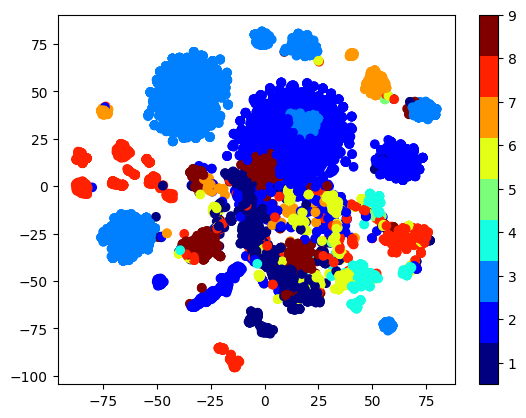

In [19]:
# Multivariate analysis on byte files
# This is with perplexity 50
xtsne = TSNE(perplexity=50)
results = xtsne.fit_transform(result.drop(['ID','Class'], axis=1))
vis_x = results[:, 0]
vis_y = results[:, 1]
plt.scatter(vis_x, vis_y, c=data_y, cmap=plt.cm.get_cmap("jet", 9))
plt.colorbar(ticks=range(10))
plt.clim(0.5, 9)
plt.show()

result.shape = (10868, 260) -> Normalized byte_features_with_size  
results.shape = (10868, 2) -> tSNE (2dimension)

<h1 style="font-size:120%"><b>Train Test split of only Byte Files Features </b></h1>

In [20]:
data_y = result['Class']
# split the data into test and train by maintaining same distribution of output varaible 'y_true' [stratify=y_true]
X_train, X_test, y_train, y_test = train_test_split(result.drop(['ID','Class'], axis=1), data_y, stratify=data_y, test_size=0.20)
# split the train data into train and cross validation by maintaining same distribution of output varaible 'y_train' [stratify=y_train]
X_train, X_cv, y_train, y_cv = train_test_split(X_train, y_train, stratify=y_train, test_size=0.20)

In [21]:
print('Number of data points in train data:', X_train.shape[0])
print('Number of data points in cross validation data:', X_cv.shape[0])
print('Number of data points in test data:', X_test.shape[0])

Number of data points in train data: 6955
Number of data points in cross validation data: 1739
Number of data points in test data: 2174


##### Class distribution (Histogram) in train/validation/test data

In [23]:
# Check test ; y_train.value_counts()
train_class_distribution = y_train.value_counts()
train_class_distribution

3    1883
2    1586
1     986
8     786
9     648
6     481
4     304
7     254
5      27
Name: Class, dtype: int64

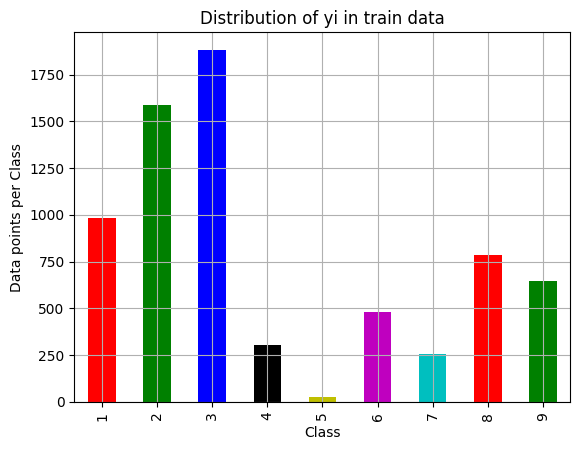

In [24]:
# it returns a dict, keys as class labels and values as the number of data points in that class

train_class_distribution = y_train.value_counts().sort_index() # Series
test_class_distribution = y_test.value_counts().sort_index()
cv_class_distribution = y_cv.value_counts().sort_index()

my_colors = ['r','g','b','k','y','m','c']
train_class_distribution.plot(kind='bar', color=my_colors)

plt.xlabel('Class')
plt.ylabel('Data points per Class')
plt.title('Distribution of yi in train data')
plt.grid()
plt.show()

In [31]:
print(train_class_distribution)
sorted_yi = np.argsort(-train_class_distribution.values)
print(sorted_yi)

1     986
2    1586
3    1883
4     304
5      27
6     481
7     254
8     786
9     648
Name: Class, dtype: int64
[2 1 0 7 8 5 3 6 4]


Number of data points in class 3 : 1883 ( 27.07 %)
Number of data points in class 2 : 1586 ( 22.8 %)
Number of data points in class 1 : 986 ( 14.18 %)
Number of data points in class 8 : 786 ( 11.3 %)
Number of data points in class 9 : 648 ( 9.32 %)
Number of data points in class 6 : 481 ( 6.92 %)
Number of data points in class 4 : 304 ( 4.37 %)
Number of data points in class 7 : 254 ( 3.65 %)
Number of data points in class 5 : 27 ( 0.39 %)
--------------------------------------------------------------------------------


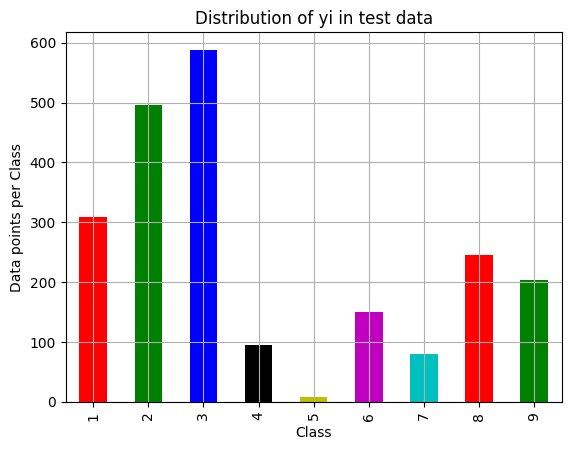

Number of data points in class 3 : 588 ( 27.047 %)
Number of data points in class 2 : 496 ( 22.815 %)
Number of data points in class 1 : 308 ( 14.167 %)
Number of data points in class 8 : 246 ( 11.316 %)
Number of data points in class 9 : 203 ( 9.338 %)
Number of data points in class 6 : 150 ( 6.9 %)
Number of data points in class 4 : 95 ( 4.37 %)
Number of data points in class 7 : 80 ( 3.68 %)
Number of data points in class 5 : 8 ( 0.368 %)
--------------------------------------------------------------------------------


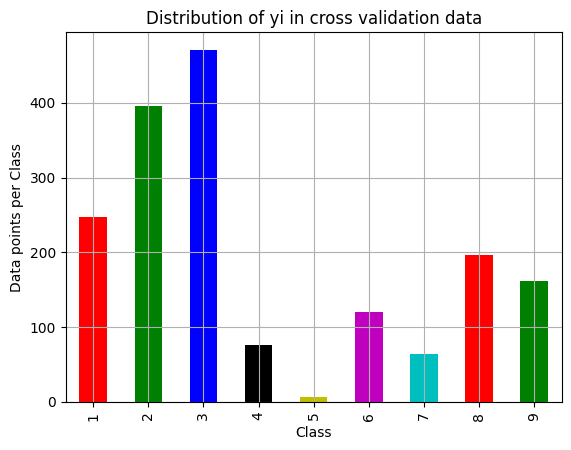

Number of data points in class 3 : 471 ( 27.085 %)
Number of data points in class 2 : 396 ( 22.772 %)
Number of data points in class 1 : 247 ( 14.204 %)
Number of data points in class 8 : 196 ( 11.271 %)
Number of data points in class 9 : 162 ( 9.316 %)
Number of data points in class 6 : 120 ( 6.901 %)
Number of data points in class 4 : 76 ( 4.37 %)
Number of data points in class 7 : 64 ( 3.68 %)
Number of data points in class 5 : 7 ( 0.403 %)


In [32]:
# ref: argsort https://docs.scipy.org/doc/numpy/reference/generated/numpy.argsort.html
# -(train_class_distribution.values): the minus sign will give us in decreasing order
sorted_yi = np.argsort(-train_class_distribution.values)
for i in sorted_yi:
    print('Number of data points in class', i+1, ':', train_class_distribution.values[i], 
          '(', np.round((train_class_distribution.values[i]/y_train.shape[0]*100), 2), '%)')

print('-'*80)
test_class_distribution.plot(kind='bar', color=my_colors)
plt.xlabel('Class')
plt.ylabel('Data points per Class')
plt.title('Distribution of yi in test data')
plt.grid()
plt.show()

sorted_yi = np.argsort(-test_class_distribution.values)
for i in sorted_yi:
    print('Number of data points in class', i+1, ':',test_class_distribution.values[i], 
          '(', np.round((test_class_distribution.values[i]/y_test.shape[0]*100), 3), '%)')

print('-'*80)
cv_class_distribution.plot(kind='bar', color=my_colors)
plt.xlabel('Class')
plt.ylabel('Data points per Class')
plt.title('Distribution of yi in cross validation data')
plt.grid()
plt.show()

sorted_yi = np.argsort(-train_class_distribution.values)
for i in sorted_yi:
    print('Number of data points in class', i+1, ':',cv_class_distribution.values[i], 
          '(', np.round((cv_class_distribution.values[i]/y_cv.shape[0]*100), 3), '%)')

##### Confusion matrix function

In [33]:
def plot_confusion_matrix(test_y, predict_y):
    C = confusion_matrix(test_y, predict_y)
    print("Number of misclassified points ", (len(test_y)-np.trace(C))/len(test_y)*100)
    # C = 9,9 matrix, each cell (i,j) represents number of points of class i are predicted class j
    
    # Recall matrix
    A = (((C.T)/(C.sum(axis=1))).T)
    
    # Precision matrix
    B = (C/C.sum(axis=0))
    
    labels = [1,2,3,4,5,6,7,8,9]
    cmap = sns.light_palette("green")

    # representing C in heatmap format
    print("-"*50, "Confusion matrix", "-"*50)
    plt.figure(figsize=(10,5))
    sns.heatmap(C, annot=True, cmap=cmap, fmt=".3f", xticklabels=labels, yticklabels=labels)
    plt.xlabel('Predicted Class')
    plt.ylabel('Original Class')
    plt.show()

    # representing B in heatmap format
    print("-"*50, "Precision matrix", "-"*50)
    plt.figure(figsize=(10,5))
    sns.heatmap(B, annot=True, cmap=cmap, fmt=".3f", xticklabels=labels, yticklabels=labels)
    plt.xlabel('Predicted Class')
    plt.ylabel('Original Class')
    plt.show()
    print("Sum of columns in precision matrix", B.sum(axis=0))
    
    # representing A in heatmap format
    print("-"*50, "Recall matrix"    , "-"*50)
    plt.figure(figsize=(10,5))
    sns.heatmap(A, annot=True, cmap=cmap, fmt=".3f", xticklabels=labels, yticklabels=labels)
    plt.xlabel('Predicted Class')
    plt.ylabel('Original Class')
    plt.show()
    print("Sum of rows in recall matrix", A.sum(axis=1))

    # Recall matrix
    A = (((C.T)/(C.sum(axis=1))).T)
    
    # divide each element of the confusion matrix with the sum of elements in that column
    
    # C = [[1, 2],   C.T = [[1, 3],
    #     [3, 4]]           [2, 4]]
    # C.sum(axis = 1)  axis=0 corresponds to columns and axis=1 corresponds to rows in 2D array
    # C.sum(axix =1) = [[3, 7]]
    # ((C.T)/(C.sum(axis=1))) = [[1/3, 3/7]
    #                           [2/3, 4/7]]
    # ((C.T)/(C.sum(axis=1))).T = [[1/3, 2/3]
    #                           [3/7, 4/7]]
    # sum of row elements = 1
    
    # Precision matrix
    B = (C/C.sum(axis=0))
    # divid each element of the confusion matrix with the sum of elements in that row
    # C = [[1, 2],
    #     [3, 4]]
    # C.sum(axis = 0)  axis=0 corresponds to columns and axis=1 corresponds to rows in 2D array
    # C.sum(axix =0) = [[4, 6]]
    # (C/C.sum(axis=0)) = [[1/4, 2/6],
    #                      [3/4, 4/6]] 

<h1 style="font-size:120%; color:#0000FF;"><b> 1) Random Model ONLY on bytes files </b></h1>

In [34]:
# Check test
rand_probs = np.random.rand(1, 9)
cv_predicted_y = ((rand_probs/sum(sum(rand_probs)))[0])

print(rand_probs)
print(cv_predicted_y)
print(sum(rand_probs))

(rand_probs/sum(sum(rand_probs)))[0]

[[0.24757333 0.83382623 0.16375271 0.39496337 0.99916407 0.36890193
  0.57052334 0.86815662 0.63635064]]
[0.04870411 0.1640353  0.03221442 0.07769956 0.19656155 0.0725726
 0.11223677 0.17078898 0.12518671]
[0.24757333 0.83382623 0.16375271 0.39496337 0.99916407 0.36890193
 0.57052334 0.86815662 0.63635064]


array([0.04870411, 0.1640353 , 0.03221442, 0.07769956, 0.19656155,
       0.0725726 , 0.11223677, 0.17078898, 0.12518671])

We need to generate 9 numbers and the sum of numbers should be 1  
One solution is to genarate 9 numbers and divide each of the numbers by their sum  
ref: https://stackoverflow.com/a/18662466/4084039

In [38]:
# Check
rand_probs = np.random.rand(1,9)
print(rand_probs)
rand_probs/sum(sum(rand_probs))

[[0.16939809 0.70245695 0.5714993  0.13303436 0.88783759 0.73555638
  0.20421278 0.52014259 0.68098837]]


array([[0.03678468, 0.15253804, 0.12410068, 0.02888832, 0.19279331,
        0.15972556, 0.04434466, 0.1129486 , 0.14787615]])

Log loss on Cross Validation Data using Random Model = 2.4766267719776325
Log loss on Test Data using Random Model = 2.511474391155353
Number of misclassified points  90.24839006439743
-------------------------------------------------- Confusion matrix --------------------------------------------------


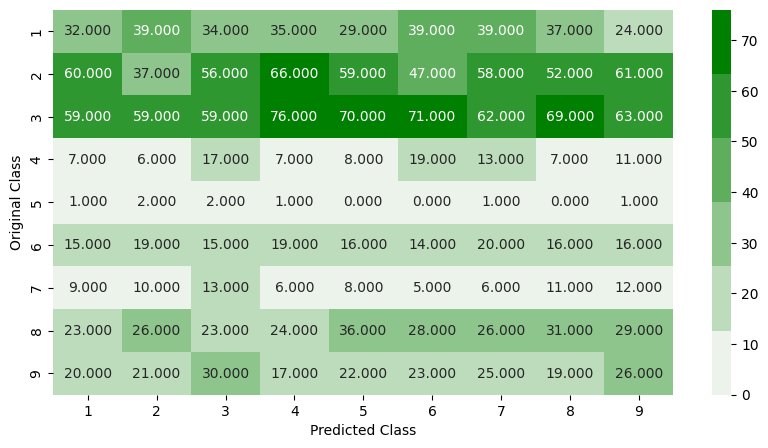

-------------------------------------------------- Precision matrix --------------------------------------------------


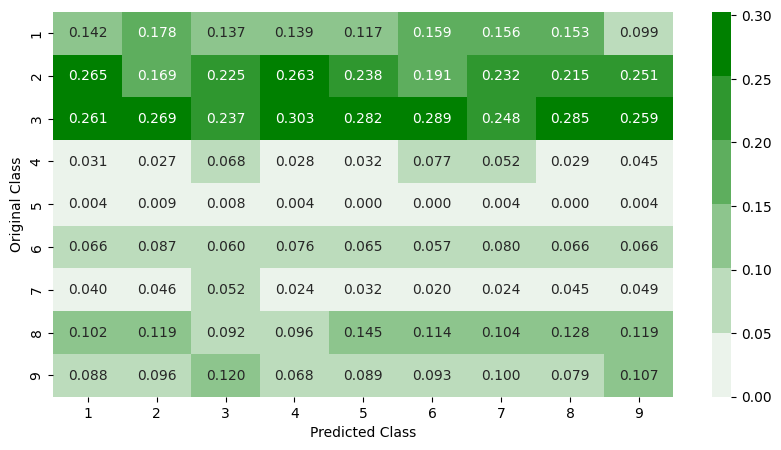

Sum of columns in precision matrix [1. 1. 1. 1. 1. 1. 1. 1. 1.]
-------------------------------------------------- Recall matrix --------------------------------------------------


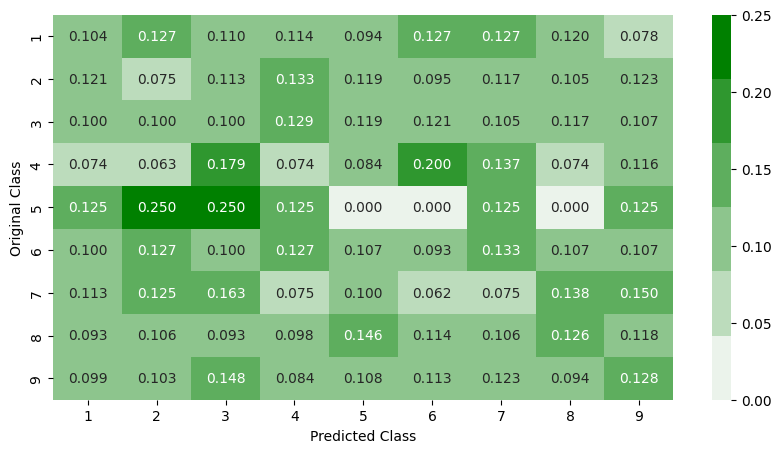

Sum of rows in recall matrix [1. 1. 1. 1. 1. 1. 1. 1. 1.]


In [35]:
test_data_len = X_test.shape[0] # 2174
cv_data_len = X_cv.shape[0] # 1739

# We create a output array that has exactly same size as the CV data
cv_predicted_y = np.zeros((cv_data_len, 9)) # 1739x9

for i in range(cv_data_len):
    rand_probs = np.random.rand(1,9)
    cv_predicted_y[i] = ((rand_probs/sum(sum(rand_probs)))[0])

print("Log loss on Cross Validation Data using Random Model =", 
      log_loss(y_cv, cv_predicted_y, eps=1e-15))

# Test-Set error.
# We create a output array that has exactly same as the test data
test_predicted_y = np.zeros((test_data_len,9))
for i in range(test_data_len):
    rand_probs = np.random.rand(1,9)
    test_predicted_y[i] = ((rand_probs/sum(sum(rand_probs)))[0])
print("Log loss on Test Data using Random Model =", 
      log_loss(y_test, test_predicted_y, eps=1e-15))

predicted_y = np.argmax(test_predicted_y, axis=1)
plot_confusion_matrix(y_test, predicted_y+1)

<h1 style="font-size:120%;color:#0000FF;"><b> 2) K Nearest Neighbour Classification ONLY on bytes files </b></h1>

**KNeighborsClassifier()**  
http://scikit-learn.org/stable/modules/generated/sklearn.neighbors.KNeighborsClassifier.html

*default parameter*  
KNeighborsClassifier(n_neighbors=5, weights=’uniform’, algorithm=’auto’, leaf_size=30, p=2, metric=’minkowski’, metric_params=None, n_jobs=1, **kwargs)

Some methods of KNeighborsClassifier()
- fit(X, y) : Fit the model using X as training data and y as target values
- predict(X) : Predict the class labels for the provided data
- predict_proba(X) : Return probability estimates for the test data X.

*****
**CalibratedClassifierCV**  
http://scikit-learn.org/stable/modules/generated/sklearn.calibration.CalibratedClassifierCV.html

*default paramters*  
sklearn.calibration.CalibratedClassifierCV(base_estimator=None, method=’sigmoid’, cv=3)

Some of the methods of CalibratedClassifierCV()
- fit(X, y[, sample_weight])	Fit the calibrated model
- get_params([deep])	Get parameters for this estimator.
- predict(X)	Predict the target of new samples.
- predict_proba(X)	Posterior probabilities of classification

log_loss for k = 1 is 0.24591872768917647
log_loss for k = 3 is 0.24409920135590435
log_loss for k = 5 is 0.2660608157656088
log_loss for k = 7 is 0.2824780896262482
log_loss for k = 9 is 0.29591001091960867
log_loss for k = 11 is 0.31146646603048167
log_loss for k = 13 is 0.3236853652379496


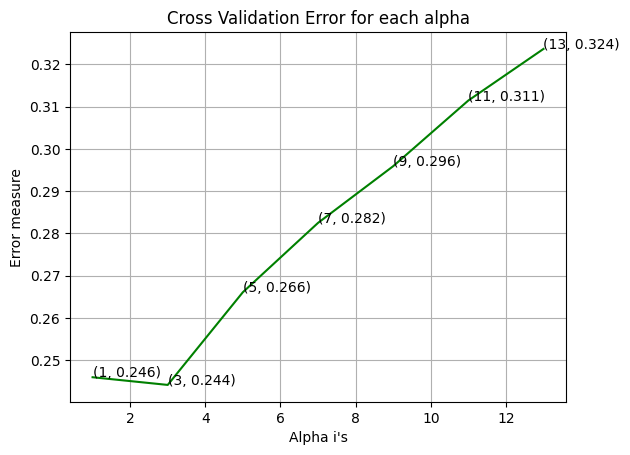

In [39]:
alpha = [x for x in range(1, 15, 2)]
cv_log_error_array=[]
for i in alpha:
    k_cfl = KNeighborsClassifier(n_neighbors=i)
    k_cfl.fit(X_train, y_train)
    sig_clf = CalibratedClassifierCV(k_cfl, method="sigmoid")
    sig_clf.fit(X_train, y_train)
    predict_y = sig_clf.predict_proba(X_cv)
    cv_log_error_array.append(log_loss(y_cv, predict_y, labels=k_cfl.classes_, eps=1e-15))
    
for i in range(len(cv_log_error_array)):
    print('log_loss for k =',alpha[i],'is',cv_log_error_array[i])

best_alpha = np.argmin(cv_log_error_array)
    
fig, ax = plt.subplots()
ax.plot(alpha, cv_log_error_array,c='g')
for i, txt in enumerate(np.round(cv_log_error_array,3)):
    ax.annotate((alpha[i],np.round(txt,3)), (alpha[i],cv_log_error_array[i]))

plt.grid()
plt.title("Cross Validation Error for each alpha")
plt.xlabel("Alpha i's")
plt.ylabel("Error measure")
plt.show()

For values of best alpha =  3 The train log loss is: 0.11657075043270763
For values of best alpha =  3 The cross validation log loss is: 0.20793224751712494
For values of best alpha =  3 The test log loss is: 0.2014374828326031
Number of misclassified points  4.967801287948482
-------------------------------------------------- Confusion matrix --------------------------------------------------


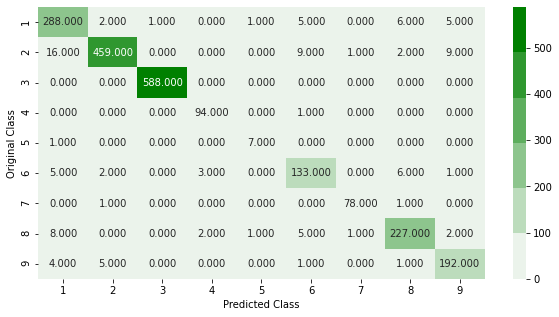

-------------------------------------------------- Precision matrix --------------------------------------------------


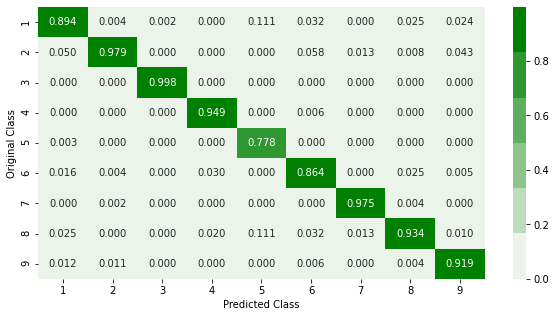

Sum of columns in precision matrix [1. 1. 1. 1. 1. 1. 1. 1. 1.]
-------------------------------------------------- Recall matrix --------------------------------------------------


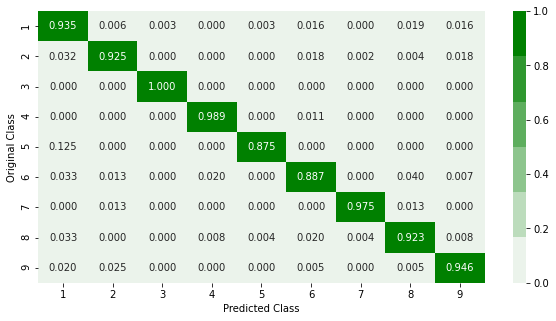

Sum of rows in recall matrix [1. 1. 1. 1. 1. 1. 1. 1. 1.]


In [28]:
k_cfl = KNeighborsClassifier(n_neighbors=alpha[best_alpha])
k_cfl.fit(X_train,y_train)
sig_clf = CalibratedClassifierCV(k_cfl, method="sigmoid")
sig_clf.fit(X_train, y_train)

predict_y = sig_clf.predict_proba(X_train)
print ('For values of best alpha = ', alpha[best_alpha], "The train log loss is:", log_loss(y_train, predict_y))
predict_y = sig_clf.predict_proba(X_cv)
print('For values of best alpha = ', alpha[best_alpha], "The cross validation log loss is:", log_loss(y_cv, predict_y))
predict_y = sig_clf.predict_proba(X_test)
print('For values of best alpha = ', alpha[best_alpha], "The test log loss is:", log_loss(y_test, predict_y))

plot_confusion_matrix(y_test, sig_clf.predict(X_test))

<h1 style="font-size:120%; color:#0000FF;"><b> 3) Logistic Regression ONLY on bytes files </b></h1>

**LogisticRegression()**  
https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LogisticRegression.html

*default parameters*  
class sklearn.linear_model.LogisticRegression(penalty='l2', *, dual=False, tol=0.0001, C=1.0, fit_intercept=True, intercept_scaling=1, class_weight=None, random_state=None, solver='lbfgs', max_iter=100, multi_class='auto', verbose=0, warm_start=False, n_jobs=None, l1_ratio=None)

some of methods
- fit(X, y[, sample_weight]) : Fit the model according to the given training data.  
- predict(X) : Predict class labels for samples in X.

log_loss for c =  1e-05 is 1.1506756830630096
log_loss for c =  0.0001 is 1.1506492215652122
log_loss for c =  0.001 is 1.1474846709312696
log_loss for c =  0.01 is 1.1217317499181307
log_loss for c =  0.1 is 1.0203916505820128
log_loss for c =  1 is 0.9639815093622307
log_loss for c =  10 is 0.9045160352343227
log_loss for c =  100 is 0.8792197995542321
log_loss for c =  1000 is 0.8826211597469932


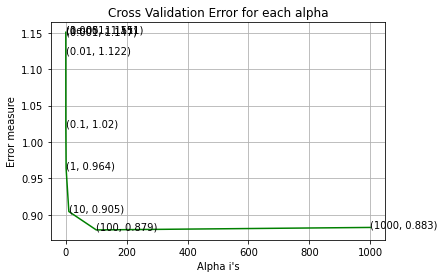

In [29]:
alpha = [10 ** x for x in range(-5, 4)]
cv_log_error_array=[]
for i in alpha:
    logisticR = LogisticRegression(penalty='l2', C=i, class_weight='balanced')
    logisticR.fit(X_train,y_train)
    sig_clf = CalibratedClassifierCV(logisticR, method="sigmoid")
    sig_clf.fit(X_train, y_train)
    predict_y = sig_clf.predict_proba(X_cv)
    cv_log_error_array.append(log_loss(y_cv, predict_y, labels=logisticR.classes_, eps=1e-15))
    
for i in range(len(cv_log_error_array)):
    print ('log_loss for c = ',alpha[i],'is',cv_log_error_array[i])

best_alpha = np.argmin(cv_log_error_array)
    
fig, ax = plt.subplots()
ax.plot(alpha, cv_log_error_array,c='g')
for i, txt in enumerate(np.round(cv_log_error_array,3)):
    ax.annotate((alpha[i],np.round(txt,3)), (alpha[i],cv_log_error_array[i]))
plt.grid()
plt.title("Cross Validation Error for each alpha")
plt.xlabel("Alpha i's")
plt.ylabel("Error measure")
plt.show()

log loss for train data 0.8760874933178403
log loss for cv data 0.8792197995542321
log loss for test data 0.868183989688114
Number of misclassified points  28.334866605335783
-------------------------------------------------- Confusion matrix --------------------------------------------------


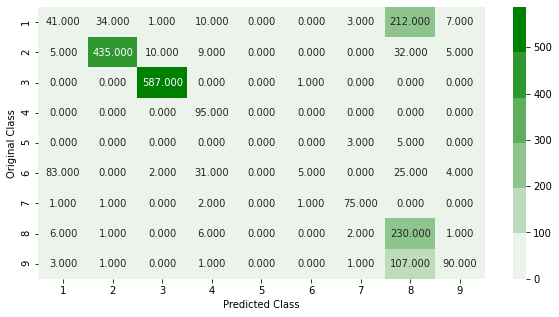

-------------------------------------------------- Precision matrix --------------------------------------------------


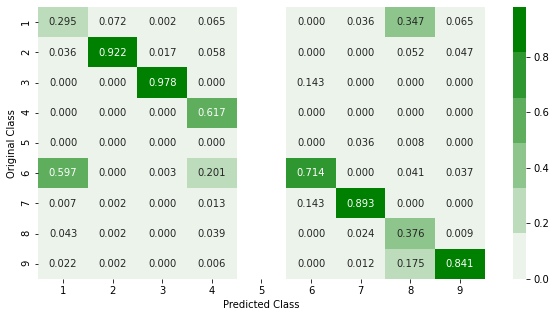

Sum of columns in precision matrix [ 1.  1.  1.  1. nan  1.  1.  1.  1.]
-------------------------------------------------- Recall matrix --------------------------------------------------


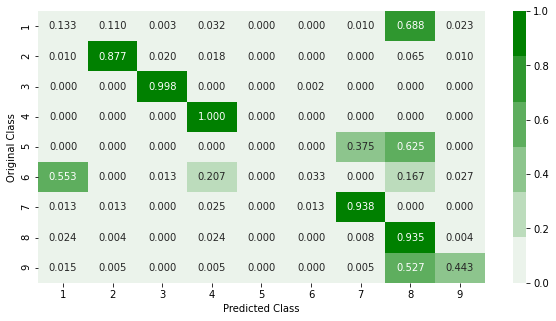

Sum of rows in recall matrix [1. 1. 1. 1. 1. 1. 1. 1. 1.]


In [30]:
logisticR = LogisticRegression(penalty='l2',C=alpha[best_alpha], class_weight='balanced')
logisticR.fit(X_train,y_train)
sig_clf = CalibratedClassifierCV(logisticR, method="sigmoid")
sig_clf.fit(X_train, y_train)
pred_y = sig_clf.predict(X_test)

predict_y = sig_clf.predict_proba(X_train)
print ('log loss for train data',log_loss(y_train, predict_y, labels=logisticR.classes_, eps=1e-15))
predict_y = sig_clf.predict_proba(X_cv)
print ('log loss for cv data',log_loss(y_cv, predict_y, labels=logisticR.classes_, eps=1e-15))
predict_y = sig_clf.predict_proba(X_test)
print ('log loss for test data',log_loss(y_test, predict_y, labels=logisticR.classes_, eps=1e-15))
plot_confusion_matrix(y_test, sig_clf.predict(X_test))

<h1 style="font-size:120%; color:#0000FF;"><b> 4) Random Forest Classifier ONLY on bytes files </b></h1>

**RandomForestClassifier**  
https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestClassifier.html?highlight=randomforestclassifier#sklearn.ensemble.RandomForestClassifier

*default parameters*  
sklearn.ensemble.RandomForestClassifier(n_estimators=10, criterion=’gini’, max_depth=None, min_samples_split=2, 
min_samples_leaf=1, min_weight_fraction_leaf=0.0, max_features=’auto’, max_leaf_nodes=None, min_impurity_decrease=0.0, 
min_impurity_split=None, bootstrap=True, oob_score=False, n_jobs=1, random_state=None, verbose=0, warm_start=False, 
class_weight=None)

Some of methods of RandomForestClassifier()  

- fit(X, y, [sample_weight]) : Fit the SVM model according to the given training data.  
- predict(X) : Perform classification on samples in X.  
- predict_proba (X) : Perform classification on samples in X.  

Some of attributes of  RandomForestClassifier()  
- feature_importances_ : array of shape = [n_features]  
- The feature importances (the higher, the more important the feature).

100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [04:05<00:00, 35.07s/it]

log_loss for c =  10 is 0.09320505471966144
log_loss for c =  50 is 0.08191010157712424
log_loss for c =  100 is 0.08099025109177878
log_loss for c =  500 is 0.07968701554347633
log_loss for c =  1000 is 0.07904391448558941
log_loss for c =  2000 is 0.07916846084757691
log_loss for c =  3000 is 0.07926442336661288


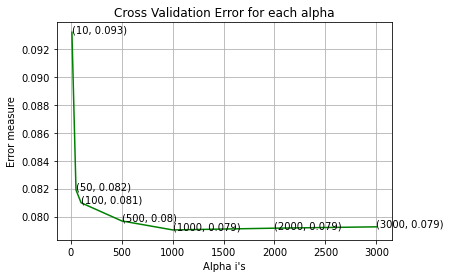

In [31]:
alpha = [10,50,100,500,1000,2000,3000]
cv_log_error_array = []
train_log_error_array = []

for i in tqdm(alpha):
    r_cfl = RandomForestClassifier(n_estimators=i,random_state=42,n_jobs=-1)
    r_cfl.fit(X_train,y_train)
    sig_clf = CalibratedClassifierCV(r_cfl, method="sigmoid")
    sig_clf.fit(X_train, y_train)
    predict_y = sig_clf.predict_proba(X_cv)
    cv_log_error_array.append(log_loss(y_cv, predict_y, labels=r_cfl.classes_, eps=1e-15))

for i in range(len(cv_log_error_array)):
    print ('log_loss for c = ',alpha[i],'is',cv_log_error_array[i])

best_alpha = np.argmin(cv_log_error_array)

fig, ax = plt.subplots()
ax.plot(alpha, cv_log_error_array,c='g')
for i, txt in enumerate(np.round(cv_log_error_array,3)):
    ax.annotate((alpha[i],np.round(txt,3)), (alpha[i],cv_log_error_array[i]))
plt.grid()
plt.title("Cross Validation Error for each alpha")
plt.xlabel("Alpha i's")
plt.ylabel("Error measure")
plt.show()

For values of best alpha =  1000 The train log loss is: 0.027375021417353824
For values of best alpha =  1000 The cross validation log loss is: 0.07904391448558941
For values of best alpha =  1000 The test log loss is: 0.06576279626669203
Number of misclassified points  1.2419503219871204
-------------------------------------------------- Confusion matrix --------------------------------------------------


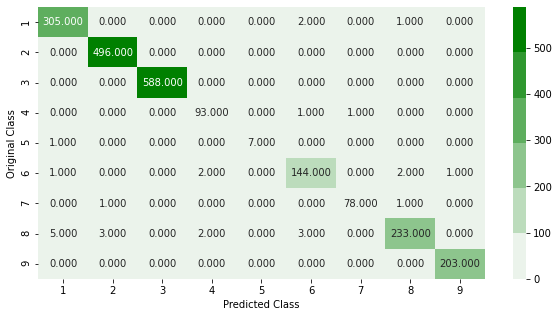

-------------------------------------------------- Precision matrix --------------------------------------------------


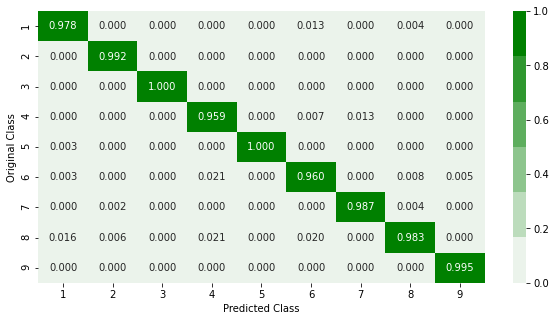

Sum of columns in precision matrix [1. 1. 1. 1. 1. 1. 1. 1. 1.]
-------------------------------------------------- Recall matrix --------------------------------------------------


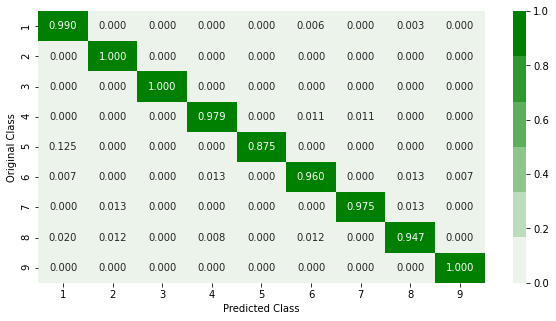

Sum of rows in recall matrix [1. 1. 1. 1. 1. 1. 1. 1. 1.]


In [32]:
r_cfl = RandomForestClassifier(n_estimators=alpha[best_alpha],random_state=42,n_jobs=-1)
r_cfl.fit(X_train,y_train)
sig_clf = CalibratedClassifierCV(r_cfl, method="sigmoid")
sig_clf.fit(X_train, y_train)

predict_y = sig_clf.predict_proba(X_train)
print('For values of best alpha = ', alpha[best_alpha], "The train log loss is:",log_loss(y_train, predict_y))
predict_y = sig_clf.predict_proba(X_cv)
print('For values of best alpha = ', alpha[best_alpha], "The cross validation log loss is:",log_loss(y_cv, predict_y))
predict_y = sig_clf.predict_proba(X_test)
print('For values of best alpha = ', alpha[best_alpha], "The test log loss is:",log_loss(y_test, predict_y))
plot_confusion_matrix(y_test, sig_clf.predict(X_test))

<h1 style="font-size:120%; color:#0000ff;"><b> 5) XgBoost Classification ONLY on bytes files </b></h1>

**Training a hyper-parameter tuned Xg-Boost regressor on our train data**  

**XGBClassifier function**   
http://xgboost.readthedocs.io/en/latest/python/python_api.html?#xgboost.XGBClassifier

*default paramters*  
class xgboost.XGBClassifier(max_depth=3, learning_rate=0.1, n_estimators=100, silent=True, 
objective='binary:logistic', booster='gbtree', n_jobs=1, nthread=None, gamma=0, min_child_weight=1, 
max_delta_step=0, subsample=1, colsample_bytree=1, colsample_bylevel=1, reg_alpha=0, reg_lambda=1, 
scale_pos_weight=1, base_score=0.5, random_state=0, seed=None, missing=None, **kwargs)

Some of methods of RandomForestRegressor()
- fit(X, y, sample_weight=None, eval_set=None, eval_metric=None, early_stopping_rounds=None, verbose=True, xgb_model=None)
- get_params([deep]) : Get parameters for this estimator.
- predict(data, output_margin=False, ntree_limit=0) : Predict with data. NOTE: This function is not thread safe.
- get_score(importance_type='weight') : get the feature importance

log_loss for c =  10 is 0.10458789836166561
log_loss for c =  50 is 0.08363539339275651
log_loss for c =  100 is 0.08180471359381555
log_loss for c =  500 is 0.0803830404446303
log_loss for c =  1000 is 0.08068892563746975
log_loss for c =  2000 is 0.08138891226690421


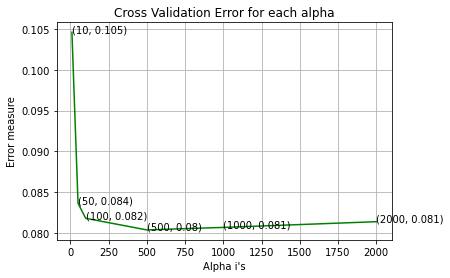

In [33]:
alpha=[10,50,100,500,1000,2000]
cv_log_error_array=[]

for i in alpha:
    x_cfl = XGBClassifier(n_estimators=i, nthread=-1, eval_metric='mlogloss')
    x_cfl.fit(X_train, y_train)
    sig_clf = CalibratedClassifierCV(x_cfl, method="sigmoid")
    sig_clf.fit(X_train, y_train)
    predict_y = sig_clf.predict_proba(X_cv)
    cv_log_error_array.append(log_loss(y_cv, predict_y, labels=x_cfl.classes_, eps=1e-15))

for i in range(len(cv_log_error_array)):
    print ('log_loss for c = ',alpha[i],'is',cv_log_error_array[i])

best_alpha = np.argmin(cv_log_error_array)

fig, ax = plt.subplots()
ax.plot(alpha, cv_log_error_array, c='g')
for i, txt in enumerate(np.round(cv_log_error_array,3)):
    ax.annotate((alpha[i],np.round(txt,3)), (alpha[i],cv_log_error_array[i]))
plt.grid()
plt.title("Cross Validation Error for each alpha")
plt.xlabel("Alpha i's")
plt.ylabel("Error measure")
plt.show()

For values of best alpha =  500 The train log loss is: 0.0227566490783331
For values of best alpha =  500 The cross validation log loss is: 0.0803830404446303
For values of best alpha =  500 The test log loss is: 0.06775352136854422
Number of misclassified points  1.1499540018399264
-------------------------------------------------- Confusion matrix --------------------------------------------------


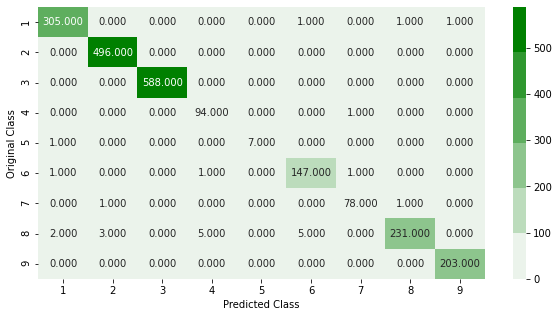

-------------------------------------------------- Precision matrix --------------------------------------------------


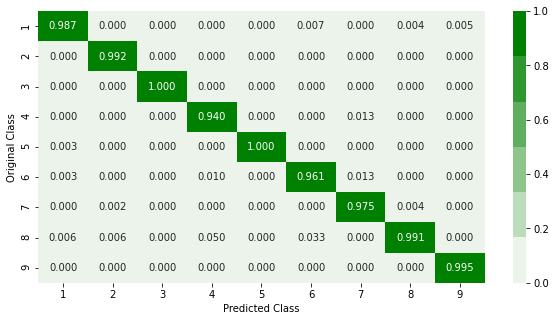

Sum of columns in precision matrix [1. 1. 1. 1. 1. 1. 1. 1. 1.]
-------------------------------------------------- Recall matrix --------------------------------------------------


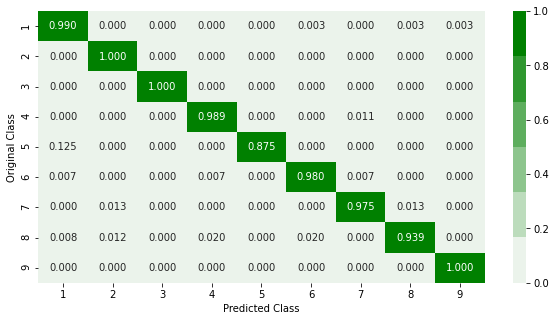

Sum of rows in recall matrix [1. 1. 1. 1. 1. 1. 1. 1. 1.]


In [34]:
x_cfl = XGBClassifier(n_estimators=alpha[best_alpha], nthread=-1,  eval_metric='mlogloss')
x_cfl.fit(X_train,y_train)
sig_clf = CalibratedClassifierCV(x_cfl, method="sigmoid")
sig_clf.fit(X_train, y_train)

predict_y = sig_clf.predict_proba(X_train)
print ('For values of best alpha = ', alpha[best_alpha], "The train log loss is:", log_loss(y_train, predict_y))
predict_y = sig_clf.predict_proba(X_cv)
print('For values of best alpha = ', alpha[best_alpha], "The cross validation log loss is:", log_loss(y_cv, predict_y))
predict_y = sig_clf.predict_proba(X_test)
print('For values of best alpha = ', alpha[best_alpha], "The test log loss is:", log_loss(y_test, predict_y))
plot_confusion_matrix(y_test, sig_clf.predict(X_test))

<h1 style="font-size:120%; color:#0000ff;"><b> 6) XgBoost Classification with best hyper parameters using RandomSearch ONLY on bytes files </b></h1>

In [35]:
x_cfl = XGBClassifier(eval_metric='mlogloss')

prams={
    'learning_rate':[0.01,0.03,0.05,0.1,0.15,0.2],
     'n_estimators':[100,200,500,1000,2000],
     'max_depth':[3,5,10],
    'colsample_bytree':[0.1,0.3,0.5,1],
    'subsample':[0.1,0.3,0.5,1]
}
random_cfl1 = RandomizedSearchCV(x_cfl, param_distributions=prams, verbose=10, n_jobs=-1,)
random_cfl1.fit(X_train, y_train)

Fitting 5 folds for each of 10 candidates, totalling 50 fits


RandomizedSearchCV(estimator=XGBClassifier(base_score=None, booster=None,
                                           colsample_bylevel=None,
                                           colsample_bynode=None,
                                           colsample_bytree=None,
                                           eval_metric='mlogloss', gamma=None,
                                           gpu_id=None, importance_type='gain',
                                           interaction_constraints=None,
                                           learning_rate=None,
                                           max_delta_step=None, max_depth=None,
                                           min_child_weight=None, missing=nan,
                                           monotone_constraints=None...
                                           random_state=None, reg_alpha=None,
                                           reg_lambda=None,
                                           scale_pos_weight=Non

**Training a hyper-parameter tuned Xg-Boost regressor on our train data**  

**sklearn.model_selection.RandomizedSearchCV**  
https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.RandomizedSearchCV.html

*default paramters*  
class sklearn.model_selection.RandomizedSearchCV(estimator, param_distributions, *, n_iter=10, scoring=None, n_jobs=None, refit=True, cv=None, verbose=0, pre_dispatch='2*n_jobs', random_state=None, error_score=nan, return_train_score=False)

Some of methods of RandomForestRegressor()
- fit(X, y, sample_weight=None, eval_set=None, eval_metric=None, early_stopping_rounds=None, verbose=True, xgb_model=None)
- get_params([deep])	Get parameters for this estimator.
- predict(data, output_margin=False, ntree_limit=0) : Predict with data. NOTE: This function is not thread safe.
- get_score(importance_type='weight') -> get the feature importance

In [36]:
x_cfl = XGBClassifier(gpu_id=0, tree_method='gpu_hist', eval_metric='mlogloss')

prams={
    'learning_rate':[0.01,0.03,0.05,0.1,0.15,0.2],
     'n_estimators':[100,200,500,1000,2000],
     'max_depth':[3,5,10],
    'colsample_bytree':[0.1,0.3,0.5,1],
    'subsample':[0.1,0.3,0.5,1]
}

random_cfl1 = RandomizedSearchCV(x_cfl, param_distributions=prams, verbose=10, n_jobs=-1,)
random_cfl1.fit(X_train,y_train)

Fitting 5 folds for each of 10 candidates, totalling 50 fits


RandomizedSearchCV(estimator=XGBClassifier(base_score=None, booster=None,
                                           colsample_bylevel=None,
                                           colsample_bynode=None,
                                           colsample_bytree=None,
                                           eval_metric='mlogloss', gamma=None,
                                           gpu_id=0, importance_type='gain',
                                           interaction_constraints=None,
                                           learning_rate=None,
                                           max_delta_step=None, max_depth=None,
                                           min_child_weight=None, missing=nan,
                                           monotone_constraints=None,
                                           n_...
                                           random_state=None, reg_alpha=None,
                                           reg_lambda=None,
                   

In [37]:
print(random_cfl1.best_params_)

{'subsample': 0.5, 'n_estimators': 2000, 'max_depth': 10, 'learning_rate': 0.1, 'colsample_bytree': 0.5}


#### XGBoost GPU Support  
https://xgboost.readthedocs.io/en/latest/gpu/index.html

##### CUDA Accelerated Tree Construction Algorithms  
Tree construction (training) and prediction can be accelerated with CUDA-capable GPUs.

In [38]:
x_cfl = XGBClassifier(random_cfl1.best_params_, gpu_id=0, tree_method='gpu_hist', eval_metric='mlogloss')

x_cfl.fit(X_train,y_train)
c_cfl = CalibratedClassifierCV(x_cfl, method='sigmoid')
c_cfl.fit(X_train,y_train)

predict_y = c_cfl.predict_proba(X_train)
print('train loss',log_loss(y_train, predict_y))
predict_y = c_cfl.predict_proba(X_cv)
print('cv loss',log_loss(y_cv, predict_y))
predict_y = c_cfl.predict_proba(X_test)
print('test loss',log_loss(y_test, predict_y))

train loss 0.02373814030435811
cv loss 0.07803456669689394
test loss 0.0654467244553628
